**Bearing Failure Anomaly Detection**

In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

**ベアリング障害の異常検出**

このワークブックでは、オートエンコーダニューラルネットワークを使用して、ベアリングセットのセンサーの読み取り値から振動異常を特定します。 目標は、将来のベアリングの故障が発生する前に予測できるようにすることです。 振動センサーの読み取り値は、NASAの音響および振動データベースからのものです。 各データセットは、10分間隔で記録された1秒の振動信号のスナップショットである個別のファイルで構成されています。 各ファイルには、20 kHzのサンプリングレートで方位センサーを読み取って取得した20,480個のセンサーデータポイントが含まれています。

このオートエンコーダニューラルネットワークモデルは、Keras / TensorFlowフレームワーク内のLong Short-Term Memory（LSTM）リカレントニューラルネットワーク（RNN）セルを使用して作成されます。

In [ ]:
# For a specific version:
!pip install tensorflow==1.14.0


     |████████████████████████████████| 109.2MB 49kB/s 
     |████████████████████████████████| 3.2MB 38.6MB/s 
     |████████████████████████████████| 491kB 40.0MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensor

In [ ]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [ ]:
# set random seed
seed(10)
set_random_seed(10)

Google colabにGoogle driveをマウント

リンク先をクリックしてID選択、許諾した後、許諾コードをコピーして下記に入力してください。

In [ ]:
from google import colab
colab.drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Google driveに data/bearing_data　というディレクトリ（フォルダ）作成、

NASAのセンサーデータを保存しておいて下さい。

In [ ]:
# load, average and merge sensor samples
data_dir = 'gdrive/My Drive/data/bearing_data'
!ls 'gdrive/My Drive/data/bearing_data'

2004.02.12.10.52.39  2004.02.14.17.32.39  2004.02.17.00.12.39
2004.02.12.11.02.39  2004.02.14.17.42.39  2004.02.17.00.22.39
2004.02.12.11.12.39  2004.02.14.17.52.39  2004.02.17.00.32.39
2004.02.12.11.22.39  2004.02.14.18.02.39  2004.02.17.00.42.39
2004.02.12.11.32.39  2004.02.14.18.12.39  2004.02.17.00.52.39
2004.02.12.11.42.39  2004.02.14.18.22.39  2004.02.17.01.02.39
2004.02.12.11.52.39  2004.02.14.18.32.39  2004.02.17.01.12.39
2004.02.12.12.02.39  2004.02.14.18.42.39  2004.02.17.01.22.39
2004.02.12.12.12.39  2004.02.14.18.52.39  2004.02.17.01.32.39
2004.02.12.12.22.39  2004.02.14.19.02.39  2004.02.17.01.42.39
2004.02.12.12.32.39  2004.02.14.19.12.39  2004.02.17.01.52.39
2004.02.12.12.42.39  2004.02.14.19.22.39  2004.02.17.02.02.39
2004.02.12.12.52.39  2004.02.14.19.32.39  2004.02.17.02.12.39
2004.02.12.13.02.39  2004.02.14.19.42.39  2004.02.17.02.22.39
2004.02.12.13.12.39  2004.02.14.19.52.39  2004.02.17.02.32.39
2004.02.12.13.22.39  2004.02.14.20.02.39  2004.02.17.02.42.39
2004.02.

In [ ]:
merged_data = pd.DataFrame()

**マージ作業**

複数のファイルをUNIONします。
その際、ファイル名が時刻になっているので、その値をデータに含めます。

In [ ]:
for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [ ]:
# transform data file index to datetime and sort in chronological order
# ＃データファイルインデックスを日時に変換し、時系列に並べ替え

merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define train/test data**

Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

**トレイン/テストデータの定義 **

モデルを設定する前に、トレーニング/テストデータを定義する必要があります。 これを行うには、データセットの最初の部分（通常の動作条件を表す必要があります）でトレーニングする単純な分割を実行し、ベアリングの故障につながるデータセットの残りの部分でテストします。
オートエンコーダー AutoEncoderでは正常値と異常値の違いを認識します。

In [ ]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


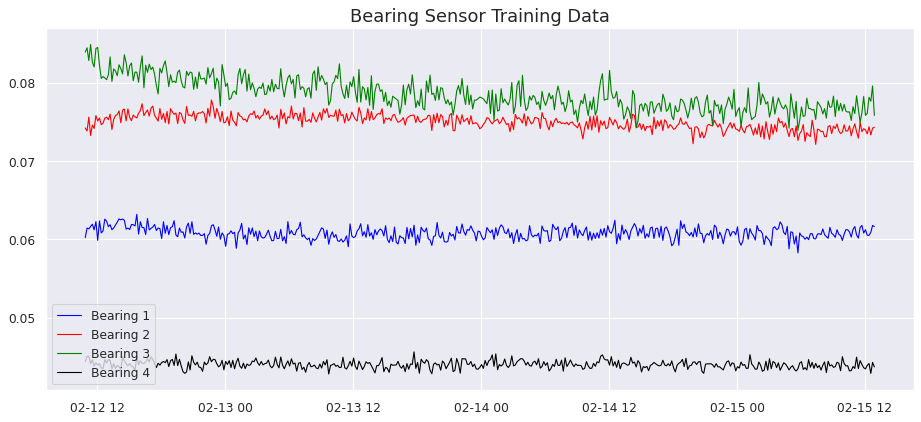

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

離散フーリエ変換を使用して信号を時間領域から周波数領域に変換することにより、データの別の視点を取得しましょう。

In [ ]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

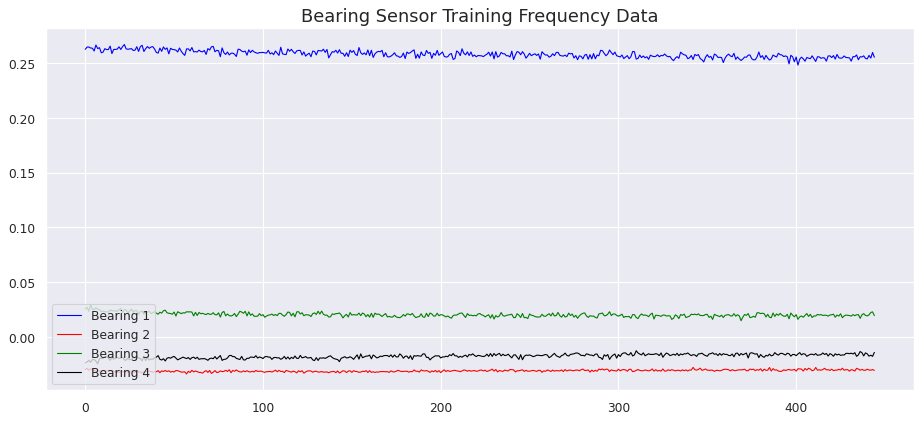

In [ ]:
# frequencies of the healthy sensor signal
#正常なセンサー信号の周波数
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

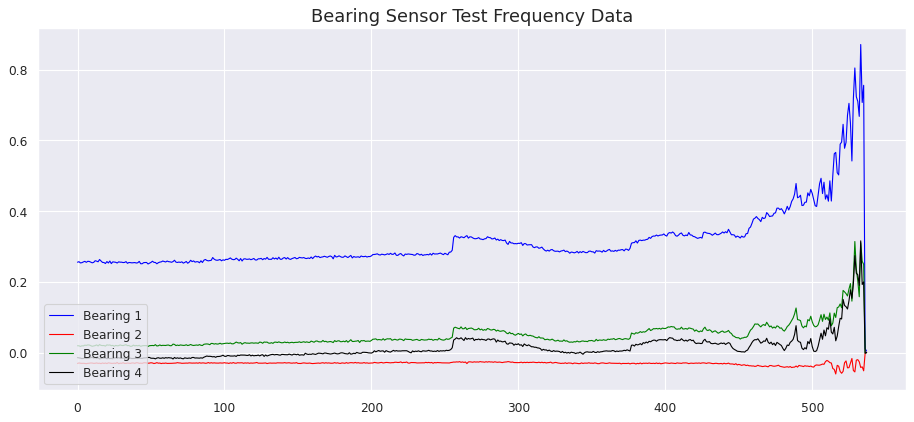

In [ ]:
# frequencies of the degrading sensor signal
# 劣化センサー信号の周波数
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
# データを正規化する
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
#LSTMの入力を再形成する[サンプル、タイムステップ、機能]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [ ]:
# define the autoencoder network model
# オートエンコーダネットワークモデルを定義する
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
# オートエンコーダーモデルの作成
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [ ]:
# fit the model to the data
# モデルをデータに合わせる
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100
422/422 [==============================] - 1s 3ms/step - loss: 0.4476 - val_loss: 0.3246
Epoch 2/100
422/422 [==============================] - 0s 420us/step - loss: 0.3896 - val_loss: 0.2574
Epoch 3/100
422/422 [==============================] - 0s 418us/step - loss: 0.3112 - val_loss: 0.1791
Epoch 4/100
422/422 [==============================] - 0s 418us/step - loss: 0.2052 - val_loss: 0.1590
Epoch 5/100
422/422 [==============================] - 0s 396us/step - loss: 0.1274 - val_loss: 0.1401
Epoch 6/100
422/422 [==============================] - 0s 399us/step - loss: 0.1084 - val_loss: 0.1230
Epoch 7/100
422/422 [==============================] - 0s 424us/step - loss: 0.1040 - val_loss: 0.1188
Epoch 8/100
422/422 [==============================] - 0s 430us/step - loss: 0.1026 - val_loss: 0.1150
Epoch 9/100
422/422 [==============================] - 0s 477us/step - loss: 0.1020 - val_loss: 0.1144
Epoch 10/100
422/422 [========

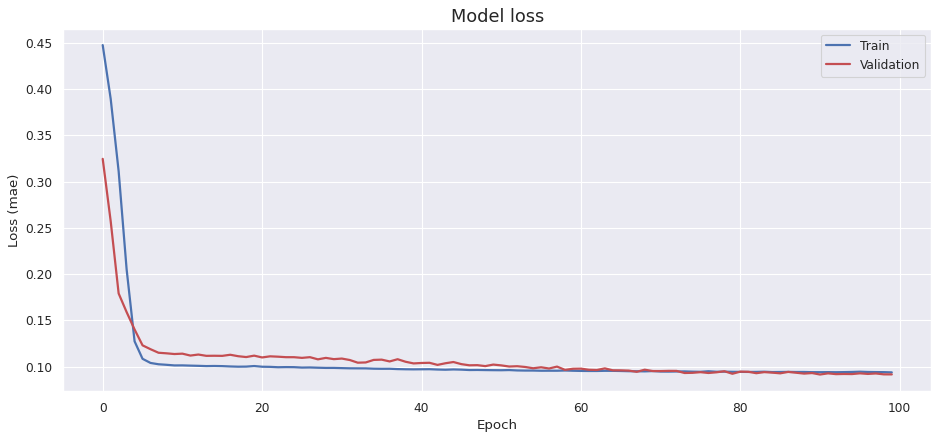

In [ ]:
# plot the training losses
#トレーニング損失をプロット
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

**Distribution of Loss Function**
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

**損失関数の分布**
トレーニングセットで計算された損失の分布をプロットすることにより、これを使用して異常を特定するための適切なしきい値を特定できます。 これを行う際に、このしきい値が「ノイズレベル」より上に設定されていること、およびフラグが付けられた異常がバックグラウンドノイズよりも統計的に有意であることを確認できます。

(0.0, 0.5)

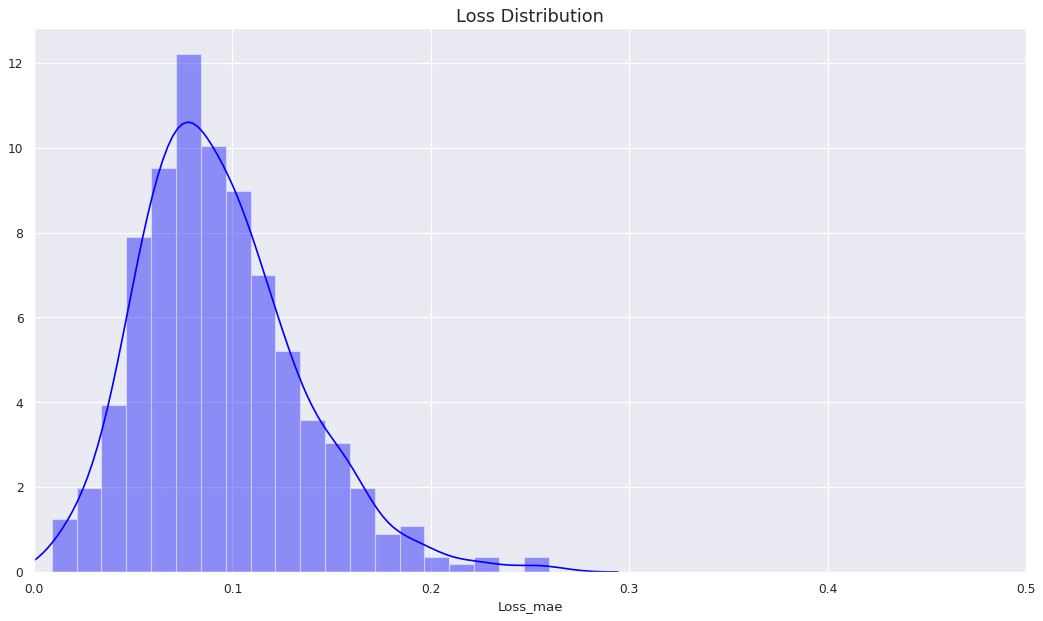

In [ ]:
# plot the loss distribution of the training set
#トレーニングセットの損失分布をプロット

X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

上記の損失分布から、異常にフラグを立てるためのしきい値0.275を試してみましょう。 次に、テストセットの損失を計算して、出力が異常しきい値を超えたときを確認できます。

In [ ]:
# calculate the loss on the test set
#＃テストセットの損失を計算する
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.093376,0.275,False
2004-02-15 13:02:39,0.177242,0.275,False
2004-02-15 13:12:39,0.067466,0.275,False
2004-02-15 13:22:39,0.050741,0.275,False
2004-02-15 13:32:39,0.042939,0.275,False


In [ ]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
#トレーニングセットと同じ指標を計算する
#プロットのために単一のデータフレーム内のすべてのデータをマージします

X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

損失分布と異常しきい値を計算したら、ベアリングの故障に至るまでの時間のモデル出力を視覚化できます。

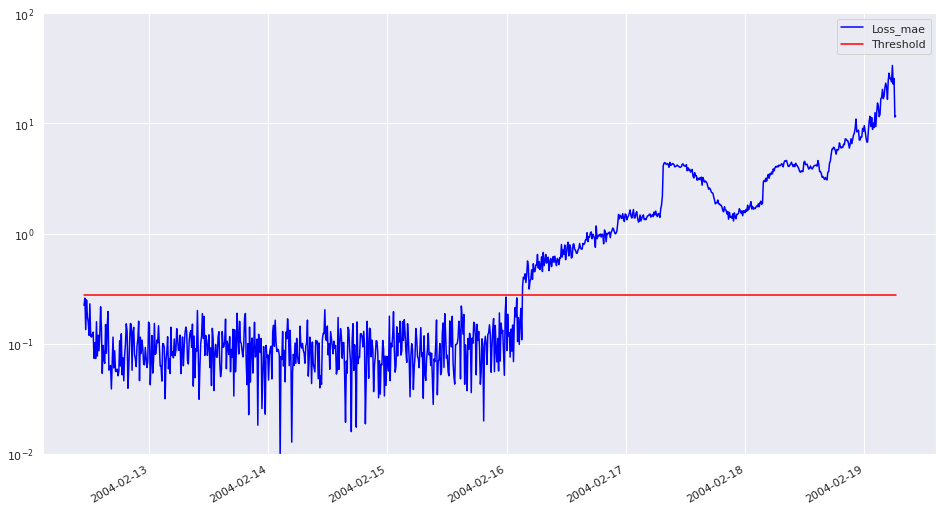

In [ ]:
# plot bearing failure time plot
# 軸受故障時間プロット
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

この分析アプローチは、実際の物理的な故障に先立って、今後のベアリングの不具合にフラグを立てることができます。 通常の動作条件での過剰な誤検知を回避しながら、異常にフラグを付けるための適切なしきい値を定義することが重要です。

In [ ]:
# save all model information, including weights, in h5 format
#重みを含むすべてのモデル情報をh5形式で保存

model.save("Cloud_model.h5")
print("Model saved")

Model saved
